In [21]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform, cosine

In [64]:
# Function to initialize logarithmic bins
def initialize_log_bins():
    '''Initialize log bins that will be used'''
    bins = []
    i = 5e3
    bins.append(i)
    index = 1
    while i < 1.6e8:
        i_new = int(i * pow(1.12, index))
        index += 1
        if i_new == i:
            i = i_new
            continue
        else:
            i = i_new
            bins.append(i)
    return bins

In [65]:
# Function to parse the text file
def parse_file(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
    total_sum = data['interaction'].sum()
    cis_contacts = data[data['chr1'] == data['chr2']]['interaction'].sum()
    trans_contacts = data[data['chr1'] != data['chr2']]['interaction'].sum()
    if trans_contacts == 0:
        cis_trans_ratio = float('inf')  # To handle division by zero
    else:
        cis_trans_ratio = cis_contacts / trans_contacts

    if total_sum >= 1000 and cis_trans_ratio >= 1:
        return data
    print(f"SKIPPED {file_path}")
    return None

def load_chr1_matrix(data, chr1_size):
    # Filter for chr1 interactions and exclude diagonal (where pos1 == pos2)
    chr1_data = data[(data['chr1'] == 'chr1') & (data['chr2'] == 'chr1') & (data['pos1'] != data['pos2'])]

    # Initialize matrix for chr1
    chr1_matrix = np.zeros((chr1_size, chr1_size))
    
    # Populate the matrix with interaction data
    for _, row in chr1_data.iterrows():
        pos1 = row['pos1'] // 1000000
        pos2 = row['pos2'] // 1000000
        interaction = row['interaction']
        if interaction != 0:
            interaction = 1
        
        if pos1 < chr1_size and pos2 < chr1_size:
            # Only update the upper triangular part
            if pos1 < pos2:
                chr1_matrix[pos1, pos2] += interaction
            elif pos2 < pos1:
                chr1_matrix[pos2, pos1] += interaction  # Ensure symmetry for intra-chromosomal interactions
    
    return np.triu(chr1_matrix)  # Ensure that only the upper triangular part is returned


# Function to load chromosome 1 matrix
def load_chr1_matrix(data, chr1_size):
    # Filter for chr1 interactions and exclude diagonal (where pos1 == pos2)
    chr1_data = data[(data['chr1'] == 'chr1') & (data['chr2'] == 'chr1') & (data['pos1'] != data['pos2'])]

    # Initialize matrix for chr1
    chr1_matrix = np.zeros((chr1_size, chr1_size))
    
    # Populate the matrix with interaction data
    for _, row in chr1_data.iterrows():
        pos1 = row['pos1'] // 1000000
        pos2 = row['pos2'] // 1000000
        interaction = row['interaction']
        
        if pos1 < chr1_size and pos2 < chr1_size:
            # Only update the upper triangular part
            if pos1 < pos2:
                chr1_matrix[pos1, pos2] += interaction
            elif pos2 < pos1:
                chr1_matrix[pos2, pos1] += interaction  # Ensure symmetry for intra-chromosomal interactions
    
    return np.triu(chr1_matrix)  # Ensure that only the upper triangular part is returned

def load_chromosome_matrix(data, chromosome, chr_size):
    # Filter for specified chromosome interactions and exclude diagonal (where pos1 == pos2)
    chr_data = data[(data['chr1'] == chromosome) & (data['chr2'] == chromosome) & (data['pos1'] != data['pos2'])]
    
    # Initialize matrix for the specified chromosome
    chr_matrix = np.zeros((chr_size, chr_size))
    
    # Populate the matrix with interaction data
    for _, row in chr_data.iterrows():
        pos1 = row['pos1'] // 1000000
        pos2 = row['pos2'] // 1000000
        interaction = row['interaction']
        
        if pos1 < chr_size and pos2 < chr_size:
            # Only update the upper triangular part
            if pos1 < pos2:
                chr_matrix[pos1, pos2] += interaction
            elif pos2 < pos1:
                chr_matrix[pos2, pos1] += interaction  # Ensure symmetry for intra-chromosomal interactions
    
    return np.triu(chr_matrix)  # Ensure that only the upper triangular part is returned

# Function to load matrices from a directory for specified chromosomes
def load_chromosome_matrices(directory, chromosomes, chr_sizes):
    chr_matrices = []
    filepaths = []
    
    for filename in tqdm(os.listdir(directory), desc="Processing files"):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            data = parse_file(filepath)
            if data is not None:
                chr_matrix = load_chromosome_matrix(data, chromosomes, chr_sizes)
                chr_matrices.append(chr_matrix)
                filepaths.append(filepath)
            else:
                print(f"Data is None for file {filepath}, skipping.")
    
    return chr_matrices, filepaths

In [66]:
# Define the directories and max_bin
directories = {
    'GM12878': './GM12878',
    'HAP1': './HAP1',
    'Hela': './Hela',
    'K562': './K562'
}

max_bin = {
    'chr1': 230,
    'chr2': 242,
    'chr3': 196,
    'chr4': 190,
    'chr5': 179,
    'chr6': 168,
    'chr7': 158,
    'chr8': 145,
    'chr9': 125,
    'chr10': 134,
    'chr11': 133,
    'chr12': 132,
    'chr13': 97,
    'chr14': 89,
    'chr15': 83,
    'chr16': 81,
    'chr17': 80,
    'chr18': 77,
    'chr19': 58,
    'chr20': 61,
    'chr21': 38,
    'chr22': 36,
    'chrX': 152
}

In [67]:
# Compute matrices for each cell type separately and concatenate
# GM12878_cells, _ = load_chr1_matrices(directories['GM12878'], max_bin['chr1'])
HAP1_cells, _ = load_chr1_matrices(directories['HAP1'], max_bin['chr1'])
Hela_cells, _ = load_chr1_matrices(directories['Hela'], max_bin['chr1'])
# K562_cells, _ = load_chr1_matrices(directories['K562'], max_bin['chr1'])

# Combine all cells from all types into one list
# all_chr1_matrices = GM12878_cells + HAP1_cells + Hela_cells + K562_cells
all_chr1_matrices = HAP1_cells + Hela_cells

Processing files: 100%|██████████| 1622/1622 [00:20<00:00, 80.84it/s]


In [68]:
test_cell = HAP1_cells[0]
print(test_cell.shape)
print(test_cell[0][0],test_cell[1][1],test_cell[2][2])

(230, 230)
0.0 0.0 0.0


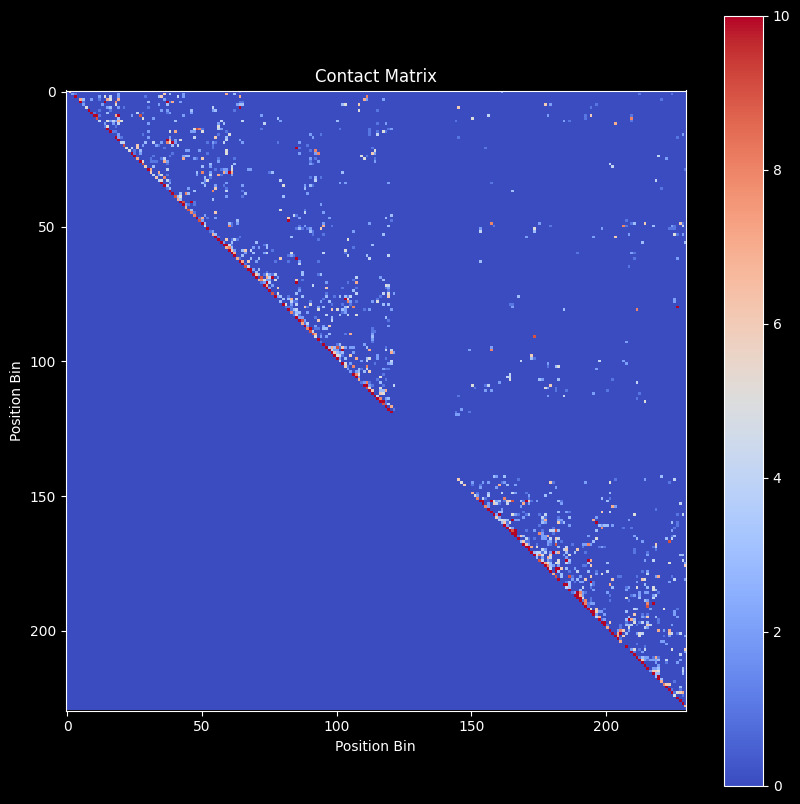

In [69]:
import matplotlib.pyplot as plt
def visualize(matrix, vmax) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(matrix, cmap='coolwarm', interpolation='none', vmin=0, vmax=vmax)
    plt.colorbar()
    plt.title('Contact Matrix')
    plt.xlabel('Position Bin')
    plt.ylabel('Position Bin')
    plt.show()

visualize(Hela_cells[4], 10)

In [70]:
data = parse_file("Hela/ml1_AACGGTCG-ATCGACGA.txt")
chr1_data = data[(data['chr1'] == 'chr1') & (data['chr2'] == 'chr1')]
chr1_data

,chr1,pos1,chr2,pos2,interaction
15,chr1,1000000,chr1,1000000,6
65,chr1,3000000,chr1,3000000,1
94,chr1,2000000,chr1,4000000,1
95,chr1,4000000,chr1,4000000,2
127,chr1,4000000,chr1,5000000,3
...,...,...,...,...,...
6409,chr1,241000000,chr1,247000000,3
6410,chr1,246000000,chr1,247000000,3
6411,chr1,247000000,chr1,247000000,9
6412,chr1,239000000,chr1,248000000,4


In [71]:
# Function to flatten and concatenate matrices of different shapes
def flatten_and_concatenate_matrices(matrices):
    flattened_vectors = [matrix.flatten() for matrix in matrices]
    concatenated_vector = np.concatenate(flattened_vectors)
    return concatenated_vector
# Function to prepare data for UMAP
def prepare_data_for_umap(cells):
    concatenated_vectors = [flatten_and_concatenate_matrices(cell) for cell in cells]
    return np.array(concatenated_vectors)

In [72]:
# Prepare data for UMAP
#GM12878_vectors = prepare_data_for_umap(GM12878_cells)
HAP1_vectors = prepare_data_for_umap(HAP1_cells)
Hela_vectors = prepare_data_for_umap(Hela_cells)
# K562_vectors = prepare_data_for_umap(K562_cells)

In [73]:
# Combine all data for UMAP
# all_vectors = np.vstack([GM12878_vectors, HAP1_vectors, Hela_vectors, K562_vectors])
all_vectors = np.vstack([HAP1_vectors, Hela_vectors])
labels = (
    [0] * len(HAP1_vectors) +
    [1] * len(Hela_vectors)
)
labels = np.array(labels)

In [33]:
import numpy as np
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt

# Flatten each matrix into a 1D vector
flattened_matrices = [matrix.flatten() for matrix in all_chr1_matrices]

# Combine the flattened matrices into a 2D array
flattened_matrices = np.array(flattened_matrices)

# Check the shape of the flattened matrices
print(f"Shape of flattened matrices: {flattened_matrices.shape}")


Shape of flattened matrices: (2539, 52900)


In [34]:
# Apply PCA to reduce dimensionality to 50 components
pca = PCA(n_components=50)
pca_result = pca.fit_transform(flattened_matrices)

# Check the shape of the PCA result
print(f"Shape after PCA: {pca_result.shape}")


Shape after PCA: (2539, 50)


In [37]:
# Apply UMAP to reduce dimensionality to 2 components
umap = UMAP(n_components=2, n_neighbors=5, min_dist=0, metric='euclidean')
umap_result = umap.fit_transform(pca_result)

# Check the shape of the UMAP result
print(f"Shape after UMAP: {umap_result.shape}")

Shape after UMAP: (2539, 2)


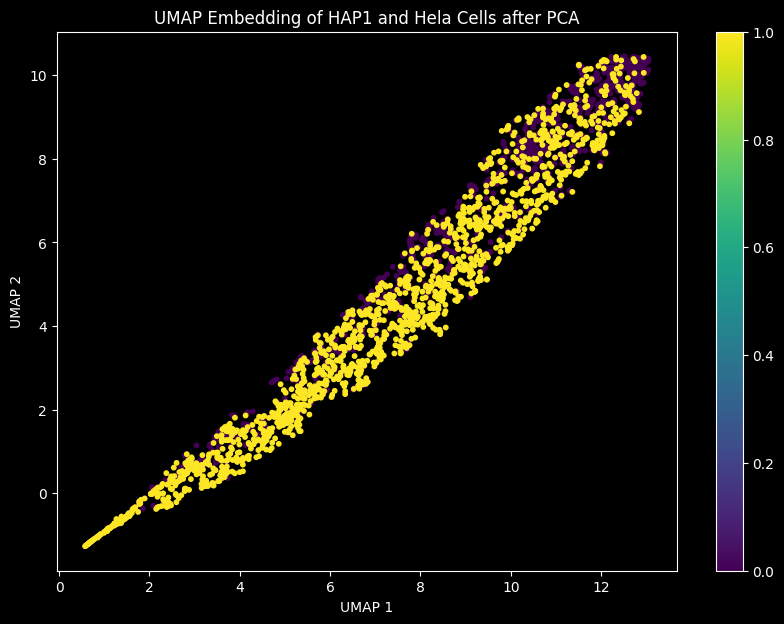

In [38]:
# Create labels for the data: 0 for HAP1, 1 for Hela
labels = [0] * len(HAP1_cells) + [1] * len(Hela_cells)

# Plot the UMAP result
plt.figure(figsize=(10, 7))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Embedding of HAP1 and Hela Cells after PCA')
plt.show()

In [29]:
import plotly.express as px
def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label 
    # so, we can maintain consistent colors for digits across multiple graphs
    
    # Concatenate X and y arrays
    arr_concat = np.concatenate((X, y.reshape(y.shape[0], 1)), axis=1)
    # Create a Pandas dataframe using the above array
    df = pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
    # Convert label data type from float to integer
    df['label'] = df['label'].astype(int)
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    
    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)

    # Update chart looks
    fig.update_layout(showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                      margin=dict(l=0, r=0, b=0, t=0),
                      scene=dict(xaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10)),
                                 yaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10)),
                                 zaxis=dict(backgroundcolor='lightgrey',
                                            color='black', 
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10))))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
    
    fig.show()

In [30]:
from umap import UMAP
# Configure UMAP hyperparameters
reducer = UMAP(n_neighbors=5, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               metric='cosine', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1, # default 1.0, The initial learning rate for the embedding optimization.
               init='random', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0, # default 0.1, The effective minimum distance between embedded points.
               random_state=10
              )
transformed_data = reducer.fit_transform(all_vectors)

/Users/rogersyang/Documents/PhD Application/Research/3D DNA Structure Heterogeneity/DNA3D/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [20]:
n_neighbors = [5]
for n in n_neighbors:
    reducer = UMAP(n_neighbors=n, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
                   n_components=3, # default 2, The dimension of the space to embed into.
                   metric='cosine', # default 'euclidean', The metric to use to compute distances in high dimensional space.
                   n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
                   learning_rate=1, # default 1.0, The initial learning rate for the embedding optimization.
                   init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
                   min_dist=0, # default 0.1, The effective minimum distance between embedded points.
                   random_state=10,
                   transform_seed=6
                  )
    transformed_data = reducer.fit_transform(all_vectors)
    chart(transformed_data, labels)

/Users/rogersyang/Documents/PhD Application/Research/3D DNA Structure Heterogeneity/DNA3D/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Direct KMeans Clustering Based on the UMAP Embedding

In [79]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Apply K-means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(transformed_data)
kmeans_labels = kmeans.labels_

Confusion Matrix:
[[573 344]
 [745 877]]
Accuracy: 0.5711
Adjusted Rand Index: 0.0197
Normalized Mutual Information: 0.0190


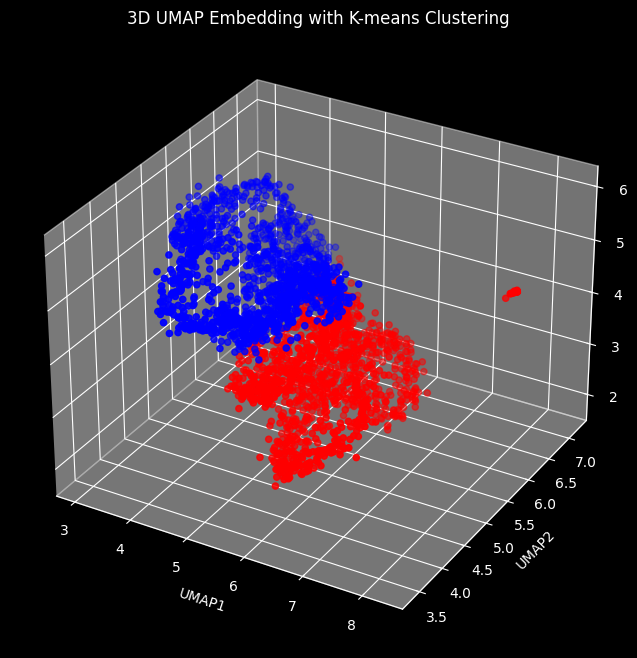

In [80]:
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, kmeans_labels)

# Use the Hungarian algorithm to find the optimal assignment
row_ind, col_ind = linear_sum_assignment(-conf_matrix)

# Create a mapping from old labels to new labels
label_mapping = {old_label: new_label for old_label, new_label in zip(col_ind, row_ind)}

# Relabel the predicted labels
relabeled_predicted_labels = np.array([label_mapping[label] for label in kmeans_labels])

# Recompute evaluation metrics
accuracy = accuracy_score(labels, relabeled_predicted_labels)
ari = adjusted_rand_score(labels, relabeled_predicted_labels)
nmi = normalized_mutual_info_score(labels, relabeled_predicted_labels)

print("Confusion Matrix:")
print(confusion_matrix(labels, relabeled_predicted_labels))
print(f"Accuracy: {accuracy:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")

# Visualize the results
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assign colors based on the relabeled predicted labels
colors = ['red' if label == 0 else 'blue' for label in relabeled_predicted_labels]

ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c=colors, marker='o')

# Set labels
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('3D UMAP Embedding with K-means Clustering')

plt.show()

In [81]:
import pandas as pd

# Create a dataframe with true labels and K-means clustered labels
df_labels = pd.DataFrame({'True Label': labels, 'K-means Clustered Label': relabeled_predicted_labels})

df_labels

,True Label,K-means Clustered Label
0,0,0
1,0,0
2,0,1
3,0,1
4,0,1
...,...,...
2534,1,1
2535,1,1
2536,1,1
2537,1,1


# KMeans Based on Pairwise Distance Matrix

In [82]:
from scipy.spatial.distance import cdist
all_chr1_matrices = HAP1_cells + Hela_cells
flattened_matrices = [matrix.flatten() for matrix in all_chr1_matrices]

flattened_matrices_array = np.array(flattened_matrices)
pairwise_distances = cdist(flattened_matrices_array, flattened_matrices_array, metric='euclidean')
print(pairwise_distances)

[[   0.          293.6971229    94.58329662 ...  301.36688604
  1762.23891683  232.21541723]
 [ 293.6971229     0.          279.49955277 ...  176.66918237
  1520.19340875  170.67513   ]
 [  94.58329662  279.49955277    0.         ...  285.89508565
  1745.98396327  210.80322578]
 ...
 [ 301.36688604  176.66918237  285.89508565 ...    0.
  1501.19285903  158.22136392]
 [1762.23891683 1520.19340875 1745.98396327 ... 1501.19285903
     0.         1572.00699744]
 [ 232.21541723  170.67513     210.80322578 ...  158.22136392
  1572.00699744    0.        ]]


[0 0 0 ... 0 1 0]


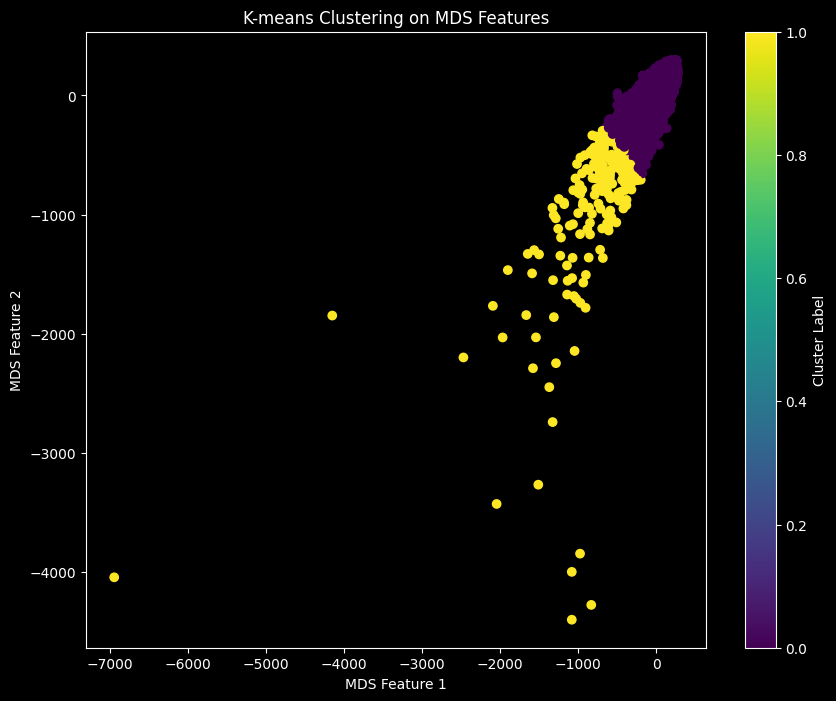

In [83]:
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

# Assuming pairwise_distances is your distance matrix
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_features = mds.fit_transform(pairwise_distances)

# mds_features is now a set of feature vectors derived from the distance matrix
# Apply K-means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(mds_features)
kmeans_labels = kmeans.labels_

print(kmeans_labels)
import matplotlib.pyplot as plt

# Plot the MDS-transformed features with K-means cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(mds_features[:, 0], mds_features[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.title('K-means Clustering on MDS Features')
plt.xlabel('MDS Feature 1')
plt.ylabel('MDS Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()


In [84]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment

# Assuming you have true labels
true_labels = labels  # Replace with your true labels

# Apply K-means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(mds_features)
kmeans_labels = kmeans.labels_

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, kmeans_labels)

# Use the Hungarian algorithm to find the optimal assignment
row_ind, col_ind = linear_sum_assignment(-conf_matrix)

# Create a mapping from old labels to new labels
label_mapping = {old_label: new_label for old_label, new_label in zip(col_ind, row_ind)}

# Relabel the predicted labels
relabeled_predicted_labels = np.array([label_mapping[label] for label in kmeans_labels])

# Recompute evaluation metrics
accuracy = accuracy_score(true_labels, relabeled_predicted_labels)
ari = adjusted_rand_score(true_labels, relabeled_predicted_labels)
nmi = normalized_mutual_info_score(true_labels, relabeled_predicted_labels)

print("Confusion Matrix:")
print(confusion_matrix(true_labels, relabeled_predicted_labels))
print(f"Accuracy: {accuracy:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")


Confusion Matrix:
[[  40  877]
 [ 139 1483]]
Accuracy: 0.5998
Adjusted Rand Index: -0.0181
Normalized Mutual Information: 0.0074


# KMeans + Agglomerative Clustering

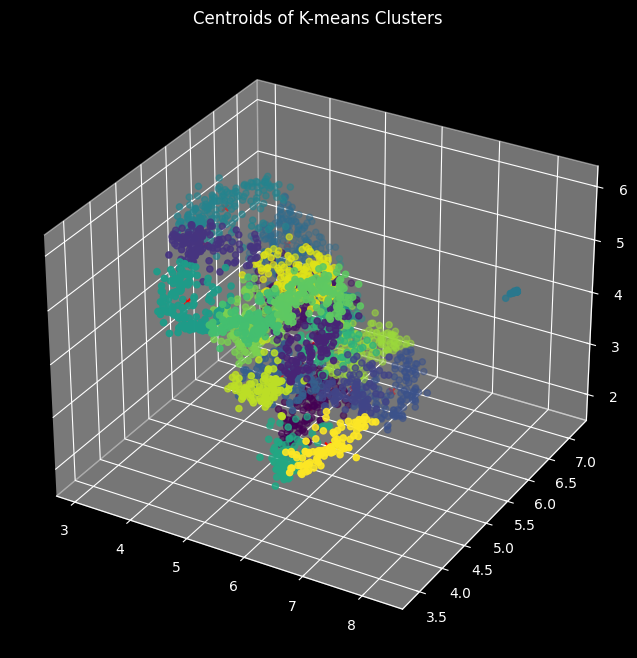

In [85]:
# First, cluster the data into a large number of clusters using K-means
n_clusters_kmeans = 21
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
kmeans.fit(transformed_data)
kmeans_labels = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_

# Plot the centroids of the K-means clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c=kmeans_labels, cmap='viridis', marker='o')
ax.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], kmeans_centroids[:, 2], c='red', marker='x')
ax.set_title('Centroids of K-means Clusters')
plt.show()


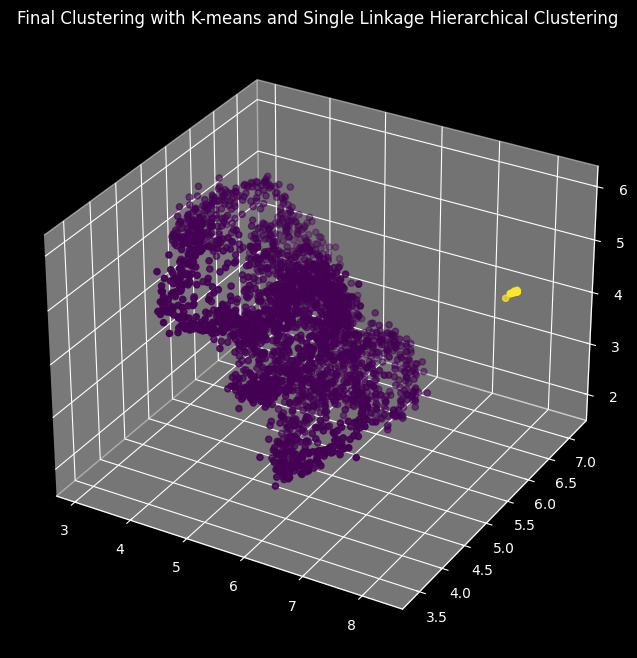

In [86]:
from sklearn.cluster import AgglomerativeClustering
# Use single linkage hierarchical clustering on the K-means centroids
agg_clustering = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='average')
agg_labels = agg_clustering.fit_predict(kmeans_centroids)

# Create a mapping from k-means labels to hierarchical cluster labels
label_mapping = {i: agg_labels[i] for i in range(n_clusters_kmeans)}

# Relabel the original data points based on the hierarchical clustering of the centroids
final_labels = np.array([label_mapping[label] for label in kmeans_labels])

# Plot the final clustering result
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c=final_labels, cmap='viridis', marker='o')
ax.set_title('Final Clustering with K-means and Single Linkage Hierarchical Clustering')
plt.show()


In [87]:
# Apply MDS to transform the distance matrix into feature vectors
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
mds_features = mds.fit_transform(pairwise_distances)


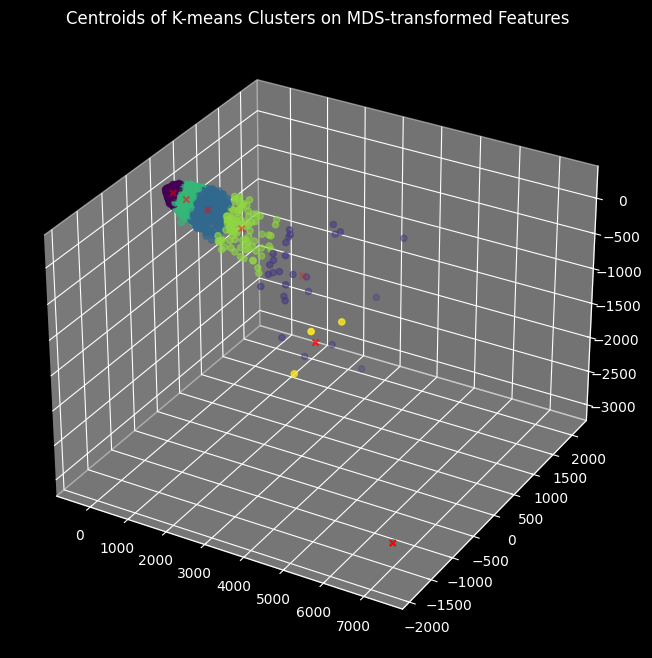

In [88]:
# Apply K-means clustering with k=21 on the MDS-transformed features
n_clusters_kmeans = 7
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
kmeans.fit(mds_features)
kmeans_labels = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_

# Plot the centroids of the K-means clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mds_features[:, 0], mds_features[:, 1], mds_features[:, 2], c=kmeans_labels, cmap='viridis', marker='o')
ax.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], kmeans_centroids[:, 2], c='red', marker='x')
ax.set_title('Centroids of K-means Clusters on MDS-transformed Features')
plt.show()


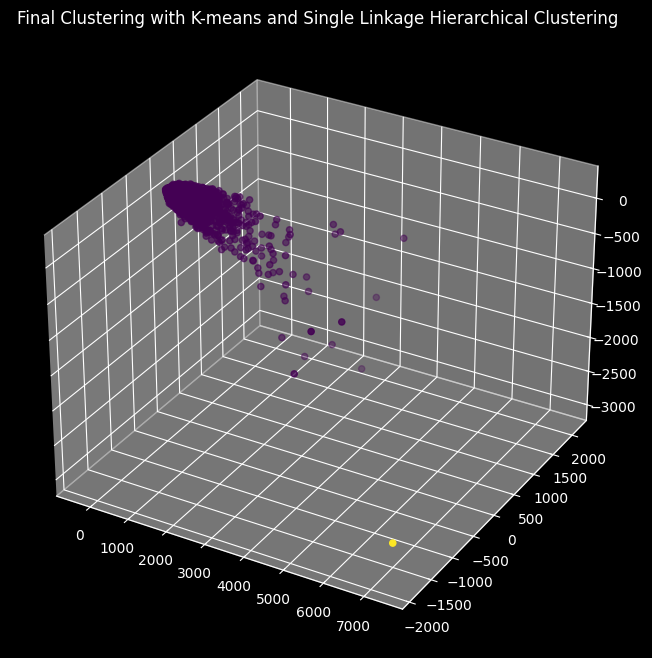

In [89]:
from sklearn.cluster import AgglomerativeClustering

# Use single linkage hierarchical clustering on the K-means centroids
agg_clustering = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='single')
agg_labels = agg_clustering.fit_predict(kmeans_centroids)

# Create a mapping from k-means labels to hierarchical cluster labels
label_mapping = {i: agg_labels[i] for i in range(n_clusters_kmeans)}

# Relabel the original data points based on the hierarchical clustering of the centroids
final_labels = np.array([label_mapping[label] for label in kmeans_labels])

# Plot the final clustering result
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mds_features[:, 0], mds_features[:, 1], mds_features[:, 2], c=final_labels, cmap='viridis', marker='o')
ax.set_title('Final Clustering with K-means and Single Linkage Hierarchical Clustering')
plt.show()


In [91]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, final_labels)

# Use the Hungarian algorithm to find the optimal assignment
row_ind, col_ind = linear_sum_assignment(-conf_matrix)

# Create a mapping from old labels to new labels
label_mapping = {old_label: new_label for old_label, new_label in zip(col_ind, row_ind)}

# Relabel the predicted labels
relabeled_predicted_labels = np.array([label_mapping[label] for label in final_labels])

# Recompute evaluation metrics
accuracy = accuracy_score(true_labels, relabeled_predicted_labels)
ari = adjusted_rand_score(true_labels, relabeled_predicted_labels)
nmi = normalized_mutual_info_score(true_labels, relabeled_predicted_labels)

print("Confusion Matrix:")
print(confusion_matrix(true_labels, relabeled_predicted_labels))
print(f"Accuracy: {accuracy:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")


Confusion Matrix:
[[   0  917]
 [   1 1621]]
Accuracy: 0.6384
Adjusted Rand Index: -0.0003
Normalized Mutual Information: 0.0005


In [22]:
for key in max_bin.keys():
    print(f"Processing chromosome {key}")
    hap1_chr, _ = load_chromosome_matrices(directories['HAP1'], key, max_bin[key])
    hela_chr, _ = load_chromosome_matrices(directories['Hela'], key, max_bin[key])
    HAP1_chr2_vectors = prepare_data_for_umap(hap1_chr)
    Hela_chr2_vectors = prepare_data_for_umap(hela_chr)
    all_vectors = np.vstack([HAP1_chr2_vectors, Hela_chr2_vectors])
    labels = (
        [0] * len(HAP1_chr2_vectors) +
        [1] * len(Hela_chr2_vectors)
    )
    labels = np.array(labels)
    transformed_data = reducer.fit_transform(all_vectors)
    # Apply K-means clustering with k=2
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(transformed_data)
    kmeans_labels = kmeans.labels_
    conf_matrix = confusion_matrix(labels, kmeans_labels)

    # Use the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)

    # Create a mapping from old labels to new labels
    label_mapping = {old_label: new_label for old_label, new_label in zip(col_ind, row_ind)}

    # Relabel the predicted labels
    relabeled_predicted_labels = np.array([label_mapping[label] for label in kmeans_labels])

    # Recompute evaluation metrics
    accuracy = accuracy_score(labels, relabeled_predicted_labels)
    ari = adjusted_rand_score(labels, relabeled_predicted_labels)
    nmi = normalized_mutual_info_score(labels, relabeled_predicted_labels)
    print(f"Direct Calculated Accuracy: {accuracy:.4f}")
    all_matrices = hap1_chr + hela_chr
    flattened_matrices = [matrix.flatten() for matrix in all_matrices]

    flattened_matrices_array = np.array(flattened_matrices)
    pairwise_distances = cdist(flattened_matrices_array, flattened_matrices_array, metric='euclidean')
    # Assuming pairwise_distances is your distance matrix
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    mds_features = mds.fit_transform(pairwise_distances)

    # mds_features is now a set of feature vectors derived from the distance matrix
    # Apply K-means clustering with k=2
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(mds_features)
    kmeans_labels = kmeans.labels_
    # Assuming you have true labels
    true_labels = labels  # Replace with your true labels

    # Apply K-means clustering with k=2
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(mds_features)
    kmeans_labels = kmeans.labels_

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_labels, kmeans_labels)

    # Use the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)

    # Create a mapping from old labels to new labels
    label_mapping = {old_label: new_label for old_label, new_label in zip(col_ind, row_ind)}

    # Relabel the predicted labels
    relabeled_predicted_labels = np.array([label_mapping[label] for label in kmeans_labels])

    # Recompute evaluation metrics
    accuracy = accuracy_score(true_labels, relabeled_predicted_labels)
    ari = adjusted_rand_score(true_labels, relabeled_predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, relabeled_predicted_labels)

    print(f"Using Pairwise Distance Accuracy: {accuracy:.4f}")
    # First, cluster the data into a large number of clusters using K-means
    n_clusters_kmeans = 7
    kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
    kmeans.fit(mds_features)
    kmeans_labels = kmeans.labels_
    kmeans_centroids = kmeans.cluster_centers_

    # Use single linkage hierarchical clustering on the K-means centroids
    agg_clustering = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='single')
    agg_labels = agg_clustering.fit_predict(kmeans_centroids)

    # Create a mapping from k-means labels to hierarchical cluster labels
    label_mapping = {i: agg_labels[i] for i in range(n_clusters_kmeans)}

    # Relabel the original data points based on the hierarchical clustering of the centroids
    final_labels = np.array([label_mapping[label] for label in kmeans_labels])

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_labels, final_labels)

    # Use the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)

    # Create a mapping from old labels to new labels
    label_mapping = {old_label: new_label for old_label, new_label in zip(col_ind, row_ind)}

    # Relabel the predicted labels
    relabeled_predicted_labels = np.array([label_mapping[label] for label in final_labels])

    # Recompute evaluation metrics
    accuracy = accuracy_score(true_labels, relabeled_predicted_labels)
    ari = adjusted_rand_score(true_labels, relabeled_predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, relabeled_predicted_labels)

    print(f"Kmeans Then Aggregate Accuracy: {accuracy:.4f}")

Processing chromosome chr1


Processing files: 100%|██████████| 1622/1622 [00:22<00:00, 71.81it/s]


Direct Calculated Accuracy: 0.5270
Using Pairwise Distance Accuracy: 0.5798
Kmeans Then Aggregate Accuracy: 0.6380
Processing chromosome chr2


Processing files: 100%|██████████| 1622/1622 [00:20<00:00, 77.63it/s]


Direct Calculated Accuracy: 0.5140
Using Pairwise Distance Accuracy: 0.5971
Kmeans Then Aggregate Accuracy: 0.6384
Processing chromosome chr3


Processing files: 100%|██████████| 1622/1622 [00:19<00:00, 83.30it/s]


Direct Calculated Accuracy: 0.5211
Using Pairwise Distance Accuracy: 0.5865
Kmeans Then Aggregate Accuracy: 0.6384
Processing chromosome chr4


Processing files: 100%|██████████| 1622/1622 [00:15<00:00, 105.91it/s]


Direct Calculated Accuracy: 0.5707
Using Pairwise Distance Accuracy: 0.6278
Kmeans Then Aggregate Accuracy: 0.6408
Processing chromosome chr5


Processing files: 100%|██████████| 1622/1622 [00:20<00:00, 79.51it/s]


Direct Calculated Accuracy: 0.5971
Using Pairwise Distance Accuracy: 0.5656
Kmeans Then Aggregate Accuracy: 0.6380
Processing chromosome chr6


Processing files: 100%|██████████| 1622/1622 [00:16<00:00, 99.03it/s] 


Direct Calculated Accuracy: 0.5140
Using Pairwise Distance Accuracy: 0.5963
Kmeans Then Aggregate Accuracy: 0.6388
Processing chromosome chr7


Processing files: 100%|██████████| 1622/1622 [00:16<00:00, 98.27it/s] 


Direct Calculated Accuracy: 0.5018
Using Pairwise Distance Accuracy: 0.5904
Kmeans Then Aggregate Accuracy: 0.6306
Processing chromosome chr8


Processing files: 100%|██████████| 1622/1622 [00:16<00:00, 97.26it/s] 


Direct Calculated Accuracy: 0.5250
Using Pairwise Distance Accuracy: 0.5746
Kmeans Then Aggregate Accuracy: 0.6384
Processing chromosome chr9


Processing files: 100%|██████████| 1622/1622 [00:13<00:00, 122.43it/s]


Direct Calculated Accuracy: 0.5108
Using Pairwise Distance Accuracy: 0.5868
Kmeans Then Aggregate Accuracy: 0.6365
Processing chromosome chr10


Processing files: 100%|██████████| 1622/1622 [00:14<00:00, 111.53it/s]


Direct Calculated Accuracy: 0.5033
Using Pairwise Distance Accuracy: 0.5939
Kmeans Then Aggregate Accuracy: 0.6384
Processing chromosome chr11


Processing files: 100%|██████████| 1622/1622 [00:15<00:00, 101.90it/s]


Direct Calculated Accuracy: 0.5648
Using Pairwise Distance Accuracy: 0.5742
Kmeans Then Aggregate Accuracy: 0.6380
Processing chromosome chr12


Processing files: 100%|██████████| 1622/1622 [00:16<00:00, 100.38it/s]


Direct Calculated Accuracy: 0.5093
Using Pairwise Distance Accuracy: 0.5805
Kmeans Then Aggregate Accuracy: 0.6380
Processing chromosome chr13


Processing files: 100%|██████████| 1622/1622 [00:12<00:00, 126.22it/s]


Direct Calculated Accuracy: 0.5490
Using Pairwise Distance Accuracy: 0.6168
Kmeans Then Aggregate Accuracy: 0.6392
Processing chromosome chr14


Processing files: 100%|██████████| 1622/1622 [00:11<00:00, 139.63it/s]


Direct Calculated Accuracy: 0.5108
Using Pairwise Distance Accuracy: 0.5829
Kmeans Then Aggregate Accuracy: 0.6380
Processing chromosome chr15


Processing files: 100%|██████████| 1622/1622 [00:11<00:00, 140.78it/s]


Direct Calculated Accuracy: 0.5163
Using Pairwise Distance Accuracy: 0.6046
Kmeans Then Aggregate Accuracy: 0.6388
Processing chromosome chr16


Processing files: 100%|██████████| 1622/1622 [00:10<00:00, 152.67it/s]


Direct Calculated Accuracy: 0.5069
Using Pairwise Distance Accuracy: 0.5884
Kmeans Then Aggregate Accuracy: 0.6380
Processing chromosome chr17


Processing files: 100%|██████████| 1622/1622 [00:10<00:00, 158.07it/s]


Direct Calculated Accuracy: 0.5037
Using Pairwise Distance Accuracy: 0.5924
Kmeans Then Aggregate Accuracy: 0.6369
Processing chromosome chr18


Processing files: 100%|██████████| 1622/1622 [00:10<00:00, 154.12it/s]


Direct Calculated Accuracy: 0.5041
Using Pairwise Distance Accuracy: 0.5987
Kmeans Then Aggregate Accuracy: 0.6384
Processing chromosome chr19


Processing files: 100%|██████████| 1622/1622 [00:08<00:00, 185.93it/s]


Direct Calculated Accuracy: 0.5049
Using Pairwise Distance Accuracy: 0.6010
Kmeans Then Aggregate Accuracy: 0.6384
Processing chromosome chr20


Processing files: 100%|██████████| 1622/1622 [00:10<00:00, 157.76it/s]


Direct Calculated Accuracy: 0.5585
Using Pairwise Distance Accuracy: 0.5758
Kmeans Then Aggregate Accuracy: 0.6380
Processing chromosome chr21


Processing files: 100%|██████████| 1622/1622 [00:08<00:00, 192.86it/s]


Direct Calculated Accuracy: 0.5128
Using Pairwise Distance Accuracy: 0.5916
Kmeans Then Aggregate Accuracy: 0.6377
Processing chromosome chr22


Processing files: 100%|██████████| 1622/1622 [00:07<00:00, 204.35it/s]


Direct Calculated Accuracy: 0.5711
Using Pairwise Distance Accuracy: 0.6329
Kmeans Then Aggregate Accuracy: 0.6396
Processing chromosome chrX


Processing files: 100%|██████████| 1622/1622 [00:15<00:00, 102.24it/s]


Direct Calculated Accuracy: 0.5128


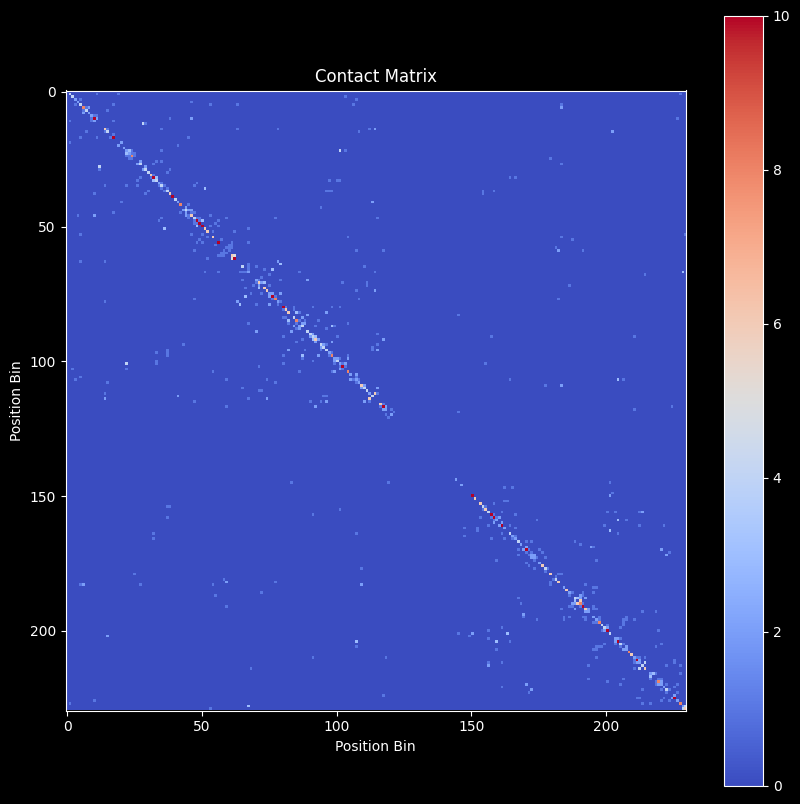

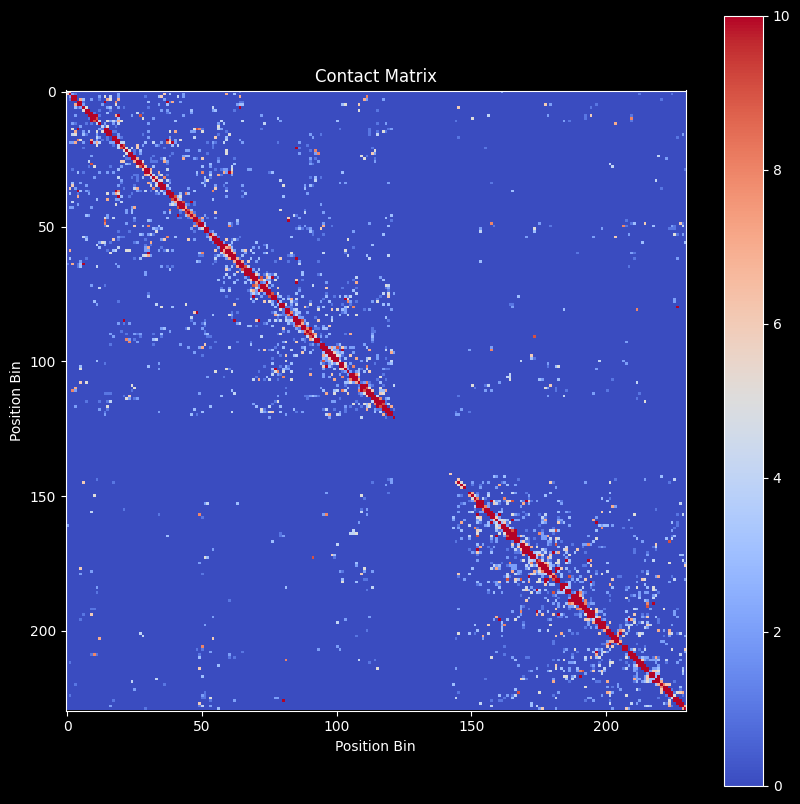

In [53]:
def visualize(matrix, vmax) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(matrix, cmap='coolwarm', interpolation='none', vmin=0, vmax=vmax)
    plt.colorbar()
    plt.title('Contact Matrix')
    plt.xlabel('Position Bin')
    plt.ylabel('Position Bin')
    plt.show()

visualize(HAP1_cells[4], 10)
visualize(Hela_cells[4], 10)